# Create SYNTHETIC dataset

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

import torch 
#import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from LOW_LEVEL_UTILITIES.utilities import show_batch, save_obj, load_obj
from LOW_LEVEL_UTILITIES.utilities import DatasetInMemory
from matplotlib.pyplot import imshow

In [58]:
params = {
    "N_MIN_OBJECTS": 2,
    "N_MAX_OBJECTS": 6,
    "MIN_OBJECT_SIZE": 20,
    "MAX_OBJECT_SIZE": 35,
    "WIDTH_RAW_IMAGE": 80,
    "HEIGHT_RAW_IMAGE": 80,
    "BACK_GROUND_MEAN":0.0,
    "BACK_GROUND_STD":0.0,
    "OBJECT_MAX_INTENSITY": 1.0,
    "OVERLAP_THRESHOLD" : 0.4
    }

In [59]:
def make_single_disks(disk_size=28,n_disk=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=disk_size).view(-1,1).expand(disk_size,disk_size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = (r2<1.0).float()
    fake_labels = disk.new_zeros(n_disk)
    return disk[None,None,...].expand(n_disk,-1,-1,-1),fake_labels

def make_single_disks_with_shading(disk_size=28,n_disk=400):
    x_mat = torch.linspace(-1.0, 1.0,steps=disk_size).view(-1,1).expand(disk_size,disk_size).float()
    y_mat = x_mat.clone().permute(1,0)
    r2   = (x_mat**2 + y_mat**2)
    disk = torch.exp(-r2)*(r2<1.0).float()
    fake_labels = disk.new_zeros(n_disk)
    return disk[None,None,...].expand(n_disk,-1,-1,-1),fake_labels

def compute_affine_aligned(bx_dimfull,by_dimfull,bw_dimfull,bh_dimfull,width_raw_image,height_raw_image):
        """ The affine matrix desxcribes the mapping between the source and the target 
            This particular affine matrix encodes only scaling and translation

            | x_s |   | sx  0   kx | | x_t |   | sx  0  | | x_t |   | kx |
            |     | = |            | | y_t | = | 0   sy | | y_t | + | ky |
            | y_s |   | 0   sy  ky | | 1   |     

            From bx,by,bw,bh dimfull we can get:
            sx =  width/bw
            sy = height/bh
            kx = (width-2*bx)/bw
            ky = (height-2*by)/bh
        """ 
        
        # Preparation the variable of interest  
        zero = (torch.zeros_like(bx_dimfull)).view(-1)
        sx = (width_raw_image/bw_dimfull).view(-1)
        sy = (height_raw_image/bh_dimfull).view(-1)
        kx = ((width_raw_image-2*bx_dimfull)/bw_dimfull).view(-1)
        ky = ((height_raw_image-2*by_dimfull)/bh_dimfull).view(-1)
        
        # Affine matrix
        affine = torch.stack((zero,sx,sy,kx,ky), dim=1)
        indeces_resampling = torch.LongTensor([1, 0, 3, 0, 2, 4]).to(affine.device) # indeces to sample: sx,0,kx,0,sy,ky
        return torch.index_select(affine, 1, indeces_resampling).view(-1,2,3) 


def create_dataset(params, dataset_single_objects, N_imgs=100):
    dataloader = torch.utils.data.DataLoader(dataset_single_objects, batch_size=params["N_MAX_OBJECTS"], shuffle=True)
    
    N_max_objects = params["N_MAX_OBJECTS"]
    width  = params["WIDTH_RAW_IMAGE"]
    height = params["HEIGHT_RAW_IMAGE"]
    delta_size = params["MAX_OBJECT_SIZE"]-params["MIN_OBJECT_SIZE"]
    delta_n_digits = params["N_MAX_OBJECTS"]-params["N_MIN_OBJECTS"]
    threshold_overlap = params["OVERLAP_THRESHOLD"] 
    
    many_objects = torch.zeros(N_max_objects,1,width,height)
    
    imgs  = torch.zeros(N_imgs,1,width,height)
    count = torch.zeros(N_imgs)

    for l in range(N_imgs):
        if(l%100 == 0):
            print(l," out of ",N_imgs)
        
        # Draw a random background
        bg = params["BACK_GROUND_MEAN"]+torch.randn(1,width,height)*params["BACK_GROUND_STD"]
        
        # Draw the random variables
        bw_dimfull = params["MIN_OBJECT_SIZE"] + delta_size*torch.rand(N_max_objects)
        bh_dimfull = bw_dimfull
        bx_dimfull = torch.rand(N_max_objects)*(width-bw_dimfull)+0.5*bw_dimfull
        by_dimfull = torch.rand(N_max_objects)*(height-bh_dimfull)+0.5*bh_dimfull
               
        # Compute the affine matrix
        affine_matrix = compute_affine_aligned(bx_dimfull,by_dimfull,bw_dimfull,bh_dimfull,width,height)
        assert(affine_matrix.shape == (N_max_objects,2,3))
    
        # Sample individual object
        single_object, labels = next(iter(dataloader))
        squares = torch.ones_like(single_object)
        grid = F.affine_grid(affine_matrix, many_objects.shape) 
        many_objects  = F.grid_sample(single_object, grid, mode='bilinear', padding_mode='zeros') 
        many_squares = (F.grid_sample(squares, grid, mode='bilinear', padding_mode='zeros') >0).float() 
        #do this so that many_suqare is a binary variable. This is NOT the case after bilinear interpolation

        # Compute the Intersection_Over_Union of the squares
        batch_size = many_squares.shape[0]
        flatten = many_squares.view(batch_size,-1)
        area = torch.sum(flatten,dim=-1)
        min_area = torch.min(area.unsqueeze(0),area.unsqueeze(1))
        intersec = torch.sum(flatten.unsqueeze(0)*flatten.unsqueeze(1),dim=-1)
        IoMIN = intersec/min_area
        cluster_mask = (IoMIN > threshold_overlap).float()
        
        # Select the non-overlapping squares
        impossible  = torch.zeros(batch_size)
        chosen      = torch.zeros(batch_size)
        while 1 < 2:
            possible = 1 - impossible
            index = torch.argmax(possible) 
            chosen[index] = 1.0
            impossible = torch.clamp(torch.matmul(cluster_mask,chosen),max=1)
            if( (impossible == 1).all() ):
                break
                
        # Count the number of non-overlapping objects
        # and select a random subset of them
        cumsum = torch.cumsum(chosen,dim=0)
        #n_chosen = int(cumsum[-1]*torch.rand(1))
        n_chosen = cumsum[-1]
        indicator = chosen*(cumsum <= n_chosen).float()              
        
        # FOREGROUND obtained by summing the non-overlapping digits
        #fg = params["OBJECT_MAX_INTENSITY"]*torch.sum(indicator[:,None,None,None]*many_objects,dim=0)    
        fg = torch.zeros_like(bg)
        pixel_already_taken = torch.zeros(width,height)
        for i in range(N_max_objects):
            if indicator[i] == 1:
                fg += (1 - pixel_already_taken) * many_objects[i]
                pixel_already_taken = (fg > 0).float()
                
        
        
        # Add the background and clamp to 1.0
        imgs[l,...] = torch.clamp(fg+bg,min=0.0,max=1.0)
        count[l] = n_chosen
        
    return imgs,count

### Single MNIST dataset and Single DISK dataset

In [60]:
#write_dir_single_MNIST = "/home/ldalessi/MNIST_DATA/"
write_dir_single_MNIST = "/home/ldalessi/DATA/SINGLE_MNIST/"

#transform = transforms.ToTensor()
#mnist_trainset = torchvision.datasets.MNIST(write_dir_single_MNIST, train=True, download=True, transform=transform)
#mnist_testset  = torchvision.datasets.MNIST(write_dir_single_MNIST, train=False, download=True, transform=transform)

#disks,labels = make_single_disks(disk_size=28,n_disk=400)
#disks_trainset = torch.utils.data.TensorDataset(disks,labels)
#disks_testset = torch.utils.data.TensorDataset(disks,labels)

disks_with_shading,labels = make_single_disks_with_shading(disk_size=28,n_disk=400)
disks_with_shading_trainset = torch.utils.data.TensorDataset(disks_with_shading,labels)
disks_with_shading_testset = torch.utils.data.TensorDataset(disks_with_shading,labels)

### Create the MULTI OBJECT DATASET from SINGLE OBJECT DATASET

In [69]:
#multi_mnist_train = create_dataset(params,mnist_trainset,N_imgs=60000)  
#multi_mnist_test = create_dataset(params,mnist_testset,N_imgs=1000) 

#multi_mnist_train = create_dataset(params,mnist_trainset,N_imgs=10)  
#multi_mnist_test = create_dataset(params,mnist_testset,N_imgs=10) 

#multi_disk_train = create_dataset(params,disks_trainset,N_imgs=10)  
#multi_disk_test = create_dataset(params,disks_testset,N_imgs=10) 

#multi_disk_train = create_dataset(params,disks_trainset,N_imgs=2000)  
#multi_disk_test = create_dataset(params,disks_testset,N_imgs=500) 

multi_disk_with_shading_train = create_dataset(params,disks_with_shading_trainset,N_imgs=2000)  
multi_disk_with_shading_test = create_dataset(params,disks_with_shading_testset,N_imgs=500)  

0  out of  2000
100  out of  2000
200  out of  2000
300  out of  2000
400  out of  2000
500  out of  2000
600  out of  2000
700  out of  2000
800  out of  2000
900  out of  2000
1000  out of  2000
1100  out of  2000
1200  out of  2000
1300  out of  2000
1400  out of  2000
1500  out of  2000
1600  out of  2000
1700  out of  2000
1800  out of  2000
1900  out of  2000
0  out of  500
100  out of  500
200  out of  500
300  out of  500
400  out of  500


imgs.shape torch.Size([2000, 1, 80, 80])
labels tensor([4., 5., 4., 4., 5., 4., 3., 4.])


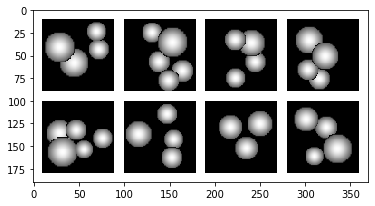

In [70]:
imgs,labels = multi_disk_with_shading_train
print("imgs.shape",imgs.shape)
print("labels",labels[:8])
show_batch(imgs[:8])

In [71]:
#imgs,labels = multi_disk_train
#print("imgs.shape",imgs.shape)
#print("labels",labels[:8])
#show_batch(imgs[:8])

In [72]:
#imgs,labels = multi_mnist_train
#print("imgs.shape",imgs.shape)
#print("labels.shape",labels.shape)
#print("labels",labels[:8])
#show_batch(imgs[:8])

### Save dataset on file

In [73]:
#write_dir_multiple_MNIST = "/home/ldalessi/MULTI_MNIST/"
#write_dir_multiple_MNIST = "/home/ldalessi/DATA/MULTI_MNIST/"

#save_obj(multi_mnist_train,write_dir_multiple_MNIST,"multi_mnist_train_large")
#save_obj(multi_mnist_test,write_dir_multiple_MNIST,"multi_mnist_test_large")


write_dir_multiple_DISK = "/home/ldalessi/MULTI_MDISK/"
write_dir_multiple_DISK = "/home/ldalessi/DATA/MULTI_DISK/"
write_dir_multiple_DISK = "/Users/ldalessi/DAPI_unsupervised/DATA/DISK_SHADING/"


#save_obj(multi_disk_train,write_dir_multiple_DISK,"multi_disk_train_with_bg")
#save_obj(multi_disk_test,write_dir_multiple_DISK,"multi_disk_test_with_bg")


save_obj(multi_disk_with_shading_train,write_dir_multiple_DISK,"multi_disk_train_shading")
save_obj(multi_disk_with_shading_test,write_dir_multiple_DISK,"multi_disk_test_shading")